In [9]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from config import BASE_DIR
from src.baselines.utils import create_adjacency_matrix
%load_ext autoreload
%autoreload 2

## Data and pre-processing

In [10]:
from config import get_paths_by_domain

exp_dir = f"{BASE_DIR}/experiments/dss/clustering_by_scroll"
DOMAIN = "dss"
paths = get_paths_by_domain(DOMAIN)

DATA_CSV_PATH = paths["data_csv_path"]

df_name = os.path.splitext(os.path.basename(DATA_CSV_PATH))[0]

df = pd.read_csv(DATA_CSV_PATH)

In [11]:
from src.baselines.embeddings import VectorizerProcessor
from src.baselines.embeddings import get_bert_models

vectorizers = get_bert_models(DOMAIN) + ["trigram", "tfidf", "starr"]

processor = VectorizerProcessor(df, paths["processed_vectorizers_path"], vectorizers)
processed_vectorizers = processor.load_or_generate_embeddings()

adjacency_matrix_all = create_adjacency_matrix(
    df,
    context_similiarity_window=3,
    composition_level=False,
)

Loaded the embeddings: ['dicta-il/BEREL', 'onlplab/alephbert-base', 'dicta-il/dictabert', 'yonatanlou/BEREL-finetuned-DSS-maskedLM', 'tfidf', 'trigram', 'starr', 'yonatanlou/alephbert-base-finetuned-DSS-maskedLM', 'yonatanlou/dictabert-finetuned-DSS-maskedLM', 'dicta-il/MsBERT']
Loaded the following embeddings dict_keys(['dicta-il/BEREL', 'onlplab/alephbert-base', 'dicta-il/dictabert', 'yonatanlou/BEREL-finetuned-DSS-maskedLM', 'tfidf', 'trigram', 'starr', 'yonatanlou/alephbert-base-finetuned-DSS-maskedLM', 'yonatanlou/dictabert-finetuned-DSS-maskedLM', 'dicta-il/MsBERT'])


Building adjacency matrix: 100%|██████████| 978/978 [00:00<00:00, 1327.52it/s]


### Add labels
For matching each chunk to it label, the main issue in in the edge cases, where the chunk have 2 labels.
Im assigning the label the majority of the chunk is in.

In [12]:
# Define your labels with their corresponding ranges
labels_1QS = {
    "1QS=1:1 – 3:12": (1, 1, 3, 12),
    "1QS=3:13 – 4:26": (3, 13, 4, 26),
    "1QS=5:1 – 6:23": (5, 1, 6, 23),
    "1QS=6:24 – 7:25": (6, 24, 7, 25),
    "1QS=8:1 – 8:19": (8, 1, 8, 19),
    "1QS=8:20 – 9:11": (8, 20, 9, 11),
    "1QS=9:12 – 9:26": (9, 12, 9, 26),
    "1QS=10:1 – 11:22": (10, 1, 11, 22),
    "1QSa=all": (1000, 1000, 1000, 1000)
}

labels_hodayot = {
    "1QHa=Non-teacher hymns": (3, 1, 8, 28),  #3:1–8:28+17:38–23:16
    "1QHa=Debated teacher hymns": (9, 1, 10, 19),  #9:1 – 10:19
    "1QHa=Teacher hymns": (10, 20, 17, 36),  #10:20 – 17:36
    "1QHa=Non-teacher hymns_2": (17, 38, 23, 16),  #3:1–8:28+17:38–23:16
    "1QHa=allTheRest": (23, 16, 1, 1)

}

labels_1QM = {
    "1QM=1:1 – 1:18": (1, 1, 1, 18),
    "1QM=allTheRest": (2, 1, 10000, 1000),

}


def parse_range(sentence_path):
    start, end = sentence_path.split('-')
    scroll = start.split(":")[0]

    start = start.split(":")[1:]
    start_chapter, start_verse = map(int, start)

    end_chapter, end_verse = map(int, end.split(':'))
    return scroll, start_chapter, start_verse, end_chapter, end_verse


def calculate_overlap(start_chapter, start_verse, end_chapter, end_verse, l_start_chapter, l_start_verse, l_end_chapter,
                      l_end_verse):
    # Convert the start and end points to a comparable single number (e.g., verse count)
    start = start_chapter * 1000 + start_verse
    end = end_chapter * 1000 + end_verse
    l_start = l_start_chapter * 1000 + l_start_verse
    l_end = l_end_chapter * 1000 + l_end_verse

    # Calculate overlap
    overlap_start = max(start, l_start)
    overlap_end = min(end, l_end)
    overlap = max(0, overlap_end - overlap_start)
    return overlap


def match_label(sentence_path, labels):
    scroll, start_chapter, start_verse, end_chapter, end_verse = parse_range(sentence_path)
    if scroll == "1QSa":
        return "1QSa"

    max_overlap = 0
    best_label = None

    for label, (l_start_chapter, l_start_verse, l_end_chapter, l_end_verse) in labels.items():
        if label.startswith(scroll):  # Ensure we are matching the correct scroll
            overlap = calculate_overlap(start_chapter, start_verse, end_chapter, end_verse, l_start_chapter,
                                        l_start_verse, l_end_chapter, l_end_verse)
            if overlap > max_overlap:
                max_overlap = overlap
                best_label = label
    if not best_label:
        best_label = [lab for lab in labels.keys() if "allTheRest" in lab][0]
    return best_label


def label_sentence_path(df_labeled_for_clustering, labels, verbose=True):
    sentence_paths = df_labeled_for_clustering["sentence_path"].to_list()
    results = []
    for sentence_path in sentence_paths:
        try:
            label = match_label(sentence_path, labels)
        except:

            label = [lab for lab in labels.keys() if "allTheRest" in lab][0]
        results.append((sentence_path, label))
        if verbose:
            print(f"Sentence Path: {sentence_path} -> Label: {label}")

    df_labeled_for_clustering = df_labeled_for_clustering.copy()
    df_labeled_for_clustering.loc[:, "label"] = [i[1] for i in results]
    df_labeled_for_clustering = df_labeled_for_clustering[
        df_labeled_for_clustering["label"] != "1QHa=allTheRest"]  #not relevant anymore
    df_labeled_for_clustering["label"] = df_labeled_for_clustering["label"].replace(
        {"1QHa=Non-teacher hymns_2": "1QHa=Non-teacher hymns"})
    return df_labeled_for_clustering

# 
# curr_scroll = ["1QHa"]
# df_labeled_for_clustering = df[df["book"].isin(curr_scroll)]
# df_labeled_for_clustering = label_sentence_path(df_labeled_for_clustering, labels_hodayot,verbose=True)
# df_labeled_for_clustering

## Functions

In [13]:

from src.baselines.utils import calculate_jaccard_unsupervised, clustering_accuracy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sknetwork.hierarchy import dasgupta_score as calculate_dasgupta_score
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
import scipy


def round_metrics(metrics, n=3):
    new_metrics = {}
    for k, v in metrics.items():
        new_metrics[k] = np.round(v, n)
    return new_metrics


def cluster_and_get_metrics(df_labeled_for_clustering, embeddings_tmp, adjacency_matrix_tmp, linkage_m):
    n_clusters = len(df_labeled_for_clustering['label'].unique())
    linkage_matrix = linkage(embeddings_tmp, method=linkage_m)

    # Calculate Jaccard Index
    flat_clusters = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
    le = LabelEncoder()
    true_labels_encoded = le.fit_transform(df_labeled_for_clustering['label'])
    jaccard = calculate_jaccard_unsupervised(true_labels_encoded, flat_clusters)
    silhouette = silhouette_score(embeddings_tmp, flat_clusters)

    dasgupta = calculate_dasgupta_score(adjacency_matrix_tmp, linkage_matrix)
    clustering_acc = clustering_accuracy(true_labels_encoded, flat_clusters)

    metrics = {
        "silhouette": silhouette,
        "jaccard": jaccard,
        "dasgupta": dasgupta,
        "clustering_accuracy": clustering_acc,
    }
    return linkage_matrix, metrics


def generate_dendrogram_plot(df_labeled_for_clustering, linkage_matrix, vec_type, metrics, curr_scroll,
                             label_to_plot="sentence_path", path_to_save=None):
    if label_to_plot not in ["sentence_path", "label"]:
        raise
    metrics = round_metrics(metrics)

    # Create a color map based on the 'label' column
    unique_labels = df_labeled_for_clustering['label'].unique()
    label_colors = plt.cm.copper(np.linspace(0, 1, len(unique_labels)))
    color_map = dict(zip(unique_labels, label_colors))

    # Plot the dendrogram
    plt.figure(figsize=(10, 14))  # Swap width and height for vertical orientation
    dendrogram(
        linkage_matrix,
        labels=df_labeled_for_clustering[label_to_plot].tolist(),
        orientation='left',  # This makes the dendrogram vertical
        leaf_font_size=6,
        leaf_rotation=0  # Horizontal text for better readability
    )
    plt.yticks(fontsize=10)

    plt.title(f'embeddings: {vec_type}, {metrics}')
    plt.ylabel('Sentence Path')  # Swap x and y labels
    plt.xlabel('Distance')
    plt.suptitle(f"{curr_scroll} scroll clustering")
    # Color the y-axis labels according to their labels
    ax = plt.gca()
    ylbls = ax.get_ymajorticklabels()
    for idx, lbl in enumerate(ylbls):
        if label_to_plot == "sentence_path":
            label = \
                df_labeled_for_clustering[df_labeled_for_clustering["sentence_path"] == lbl.get_text()]["label"].values[
                    0]
        else:
            label = lbl.get_text()
        lbl.set_color(color_map[label])
        lbl.set_text(label)

    # Add a legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                                  markerfacecolor=color, markersize=10)
                       for label, color in color_map.items()]
    plt.legend(handles=legend_elements, title='Labels', loc='best', bbox_to_anchor=(0, 1))

    plt.tight_layout()
    if path_to_save:
        plt.savefig(path_to_save)
    plt.show()


def hirerchial_clustering_by_scroll(df: pd.DataFrame, curr_scroll: list[str], labels: dict, vec_type: str,
                                    processed_vectorizers: dict, adjacency_matrix, label_to_plot, kwargs):
    linkage_m = kwargs["linkage_m"]
    #get labels
    df_labeled_for_clustering = df[df["book"].isin(curr_scroll)]
    df_labeled_for_clustering = label_sentence_path(df_labeled_for_clustering, labels, verbose=False)

    #get embeddings
    embeddings = processed_vectorizers[vec_type]
    label_idxs = list(df_labeled_for_clustering.index)
    adjacency_matrix_tmp = adjacency_matrix[label_idxs, :][
                           :, label_idxs]
    embeddings_tmp = embeddings[label_idxs]
    if type(embeddings_tmp) == scipy.sparse._csr.csr_matrix:
        embeddings_tmp = embeddings_tmp.toarray()

    #get metrics and linkage
    linkage_matrix, metrics = cluster_and_get_metrics(df_labeled_for_clustering, embeddings_tmp, adjacency_matrix_tmp,
                                                      linkage_m)

    #plot
    if label_to_plot:
        generate_dendrogram_plot(df_labeled_for_clustering, linkage_matrix, vec_type, metrics, curr_scroll,
                                 label_to_plot)
    return metrics



## P values per metric - deprecated
For constructing the p-values, im running hirerchial clustering 100 times, each time with 70% of the data.
In each itereation, im generaring random features.
Im generating 3 different metrics for each embedding type for each scroll (ari, dasgupta, jaccard).
For each metric, i can get p-value by asking for each scroll->embedding->metric is the metric is higher than the random features.
So i will get for each scroll, for each embedding, for each metric a p value.

In [14]:
# from src.baselines.utils import set_seed_globally
# from tqdm.notebook import tqdm
# 
# set_seed_globally(435)
# 
# all_scrolls_to_cluster = [["1QHa"], ["1QS", "1QSa"], ["1QM"]]
# all_labels = [labels_hodayot, labels_1QS, labels_1QM]
# linkage_methods = ['ward']
# ITERS = 50
# FRAC = 0.7
# all_res_for_p_vals = []
# for curr_scroll, labels in tqdm(zip(all_scrolls_to_cluster, all_labels)):
#     for _ in tqdm(range(ITERS)):
#         df_tmp = df[df["book"].isin(curr_scroll)]
#         df_tmp = df_tmp.sample(frac=FRAC)
#         for vec_type in vectorizers + ["random"]:
#             if vec_type == "random":
#                 processed_vectorizers["random"] = random_array = np.random.rand(df.shape[0], 1000)
#             for linkage_tmp in linkage_methods:
#                 kwargs = {"linkage_m": linkage_tmp}
#                 tmp_metrics = hirerchial_clustering_by_scroll(df_tmp, curr_scroll, labels, vec_type,
#                                                               processed_vectorizers, adjacency_matrix_all, None, kwargs)
#                 tmp_metrics.update({"vectorizer": vec_type, "scroll": curr_scroll, "n_labels": len(labels)})
#                 tmp_metrics.update(kwargs)
#                 all_res_for_p_vals.append(tmp_metrics)
# 
# 
# 
# import pandas as pd
# from scipy.stats import mannwhitneyu
# 
# # Assuming results DataFrame is already created
# results = pd.DataFrame(all_res_for_p_vals)
# results["scroll"] = results["scroll"].astype(str)
# 
# # Initialize a list to store the results
# p_values = []
# 
# # Loop through each unique scroll
# for scroll in results['scroll'].unique():
#     # Filter the results for the current scroll
#     results_one_scroll = results[results['scroll'] == scroll]
# 
#     # Loop through each unique vectorizer
#     for vectorizer in results_one_scroll['vectorizer'].unique():
#         if vectorizer == "random":
#             continue  # Skip the random vectorizer itself
# 
#         # Initialize a dictionary to store p-values for the current scroll and vectorizer
#         p_value_dict = {'scroll': scroll, 'vectorizer': vectorizer}
# 
#         # Loop through each metric: 'jaccard', 'ari', 'dasgupta'
#         for metric in ['jaccard', 'clustering_accuracy', 'silhouette', 'dasgupta']:
#             # Get the embeddings for the current vectorizer
#             tmp_embedding = results_one_scroll[results_one_scroll['vectorizer'] == vectorizer][metric]
#             random_embedding = results_one_scroll[results_one_scroll['vectorizer'] == "random"][metric]
# 
#             # Perform the Mann-Whitney U test
#             u_stat, p_value = mannwhitneyu(tmp_embedding, random_embedding)
# 
#             # Store the p-value in the dictionary
#             p_value_dict[f'{metric}_p_value'] = np.round(p_value, 6)
# 
#         # Append the dictionary to the list
#         p_values.append(p_value_dict)
# 
# # Convert the list to a DataFrame
# p_values_df = pd.DataFrame(p_values)
# 
# # Display the results
# p_values_df.sort_values(by=['scroll', 'vectorizer'], inplace=True)
# p_values_df


My main question here is which embeddings to use for each scroll.
I have 3 metrics for each scroll, embeddings with p-values.

Im running hirerchial clustering for each scroll, for each embedding (now on the full data).
Metrics that have p-value < 0.05 will become 0.
Then, i normalizing each metric, and doing a weighted average on all metrics, and taking the top for each scroll.
I can do it by two ways - 


In [15]:
# from src.baselines.utils import set_seed_globally
# from tqdm.notebook import tqdm
# 
# set_seed_globally(42)
# 
# all_scrolls_to_cluster = [["1QHa"], ["1QS", "1QSa"], ["1QM"]]
# all_labels = [labels_hodayot, labels_1QS, labels_1QM]
# linkage_methods = ['ward']
# all_res = []
# for curr_scroll, labels in tqdm(zip(all_scrolls_to_cluster, all_labels)):
#     for vec_type in vectorizers:
#         processed_vectorizers["random"] = random_array = np.random.rand(df.shape[0], 1000)
#         for linkage_tmp in linkage_methods:
#             kwargs = {"linkage_m": linkage_tmp}
#             tmp_metrics = hirerchial_clustering_by_scroll(df, curr_scroll, labels, vec_type, processed_vectorizers,
#                                                           adjacency_matrix_all, None, kwargs)
#             tmp_metrics.update({"vectorizer": vec_type, "scroll": curr_scroll, "n_labels": len(labels)})
#             tmp_metrics.update(kwargs)
#             all_res.append(tmp_metrics)
# 
# 
# import pandas as pd
# 
# def process_metrics(all_res, p_values_df, metrics, p_threshold=0.05):
#     results = pd.DataFrame(all_res)
#     results["scroll"] = results["scroll"].astype(str)
#     results = pd.merge(results, p_values_df, on=["scroll", "vectorizer"])
#     
#     # Process each metric
#     normalized_cols = []
#     rank_cols = []
#     for m in metrics:
#         # Zero out non-significant results
#         sig_col = f"{m}_w_significance"
#         results[sig_col] = results[m]
#         results.loc[results[f'{m}_p_value'] > p_threshold, sig_col] = 0
#         
#         # Normalize and rank
#         norm_col = f"{m}_normalized"
#         rank_col = f"{m}_rank"
#         results[norm_col] = results.groupby('scroll')[sig_col].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
#         results[rank_col] = results.groupby('scroll')[sig_col].rank(method='min', ascending=False)
#         
#         normalized_cols.append(norm_col)
#         rank_cols.append(rank_col)
#     
#     # Calculate combined results
#     results["normalized_results"] = results[normalized_cols].mean(axis=1)
#     results["ranked_results"] = results[rank_cols].mean(axis=1)
#     
#     return results.sort_values(by=["scroll", "normalized_results"], ascending=False)
# 
# 
# results = process_metrics(all_res, p_values_df, metrics=['jaccard', 'clustering_accuracy', 'silhouette', 'dasgupta'])
# results


### best results by Accuracy

In [16]:
from src.baselines.utils import set_seed_globally
from tqdm.notebook import tqdm

labels_all = {"['1QM']": labels_1QM, "['1QHa']": labels_hodayot, "['1QS', '1QSa']": labels_1QS}
set_seed_globally(42)

all_scrolls_to_cluster = [["1QHa"], ["1QS", "1QSa"], ["1QM"]]
all_labels = [labels_hodayot, labels_1QS, labels_1QM]
linkage_methods = ['ward']
all_res = []
for curr_scroll, labels in tqdm(zip(all_scrolls_to_cluster, all_labels)):
    for vec_type in vectorizers:
        processed_vectorizers["random"] = random_array = np.random.rand(df.shape[0], 1000)
        for linkage_tmp in linkage_methods:
            kwargs = {"linkage_m": linkage_tmp}
            tmp_metrics = hirerchial_clustering_by_scroll(df, curr_scroll, labels, vec_type, processed_vectorizers,
                                                          adjacency_matrix_all, None, kwargs)
            tmp_metrics.update({"vectorizer": vec_type, "scroll": curr_scroll, "n_labels": len(labels)})
            tmp_metrics.update(kwargs)
            all_res.append(tmp_metrics)



0it [00:00, ?it/s]

In [17]:
results = pd.DataFrame(all_res)
results["scroll"] = results["scroll"].astype(str)
results.sort_values(by=["scroll", "jaccard"], ascending=False)

,silhouette,jaccard,dasgupta,clustering_accuracy,vectorizer,scroll,n_labels,linkage_m
9,0.086068,0.523810,0.701708,0.795918,dicta-il/BEREL,"['1QS', '1QSa']",9,ward
12,0.088521,0.517766,0.733233,0.775510,yonatanlou/BEREL-finetuned-DSS-maskedLM,"['1QS', '1QSa']",9,ward
16,0.042057,0.434066,0.768369,0.653061,tfidf,"['1QS', '1QSa']",9,ward
11,0.071828,0.280172,0.590579,0.612245,dicta-il/dictabert,"['1QS', '1QSa']",9,ward
15,0.049689,0.268182,0.632572,0.551020,trigram,"['1QS', '1QSa']",9,ward
10,0.097250,0.245734,0.681909,0.612245,onlplab/alephbert-base,"['1QS', '1QSa']",9,ward
14,0.077350,0.241667,0.613665,0.571429,yonatanlou/dictabert-finetuned-DSS-maskedLM,"['1QS', '1QSa']",9,ward
13,0.089688,0.204461,0.626973,0.551020,yonatanlou/alephbert-base-finetuned-DSS-maskedLM,"['1QS', '1QSa']",9,ward
17,0.830267,0.111245,0.360693,0.285714,starr,"['1QS', '1QSa']",9,ward
24,0.198404,0.689119,0.588115,0.816327,trigram,['1QM'],2,ward


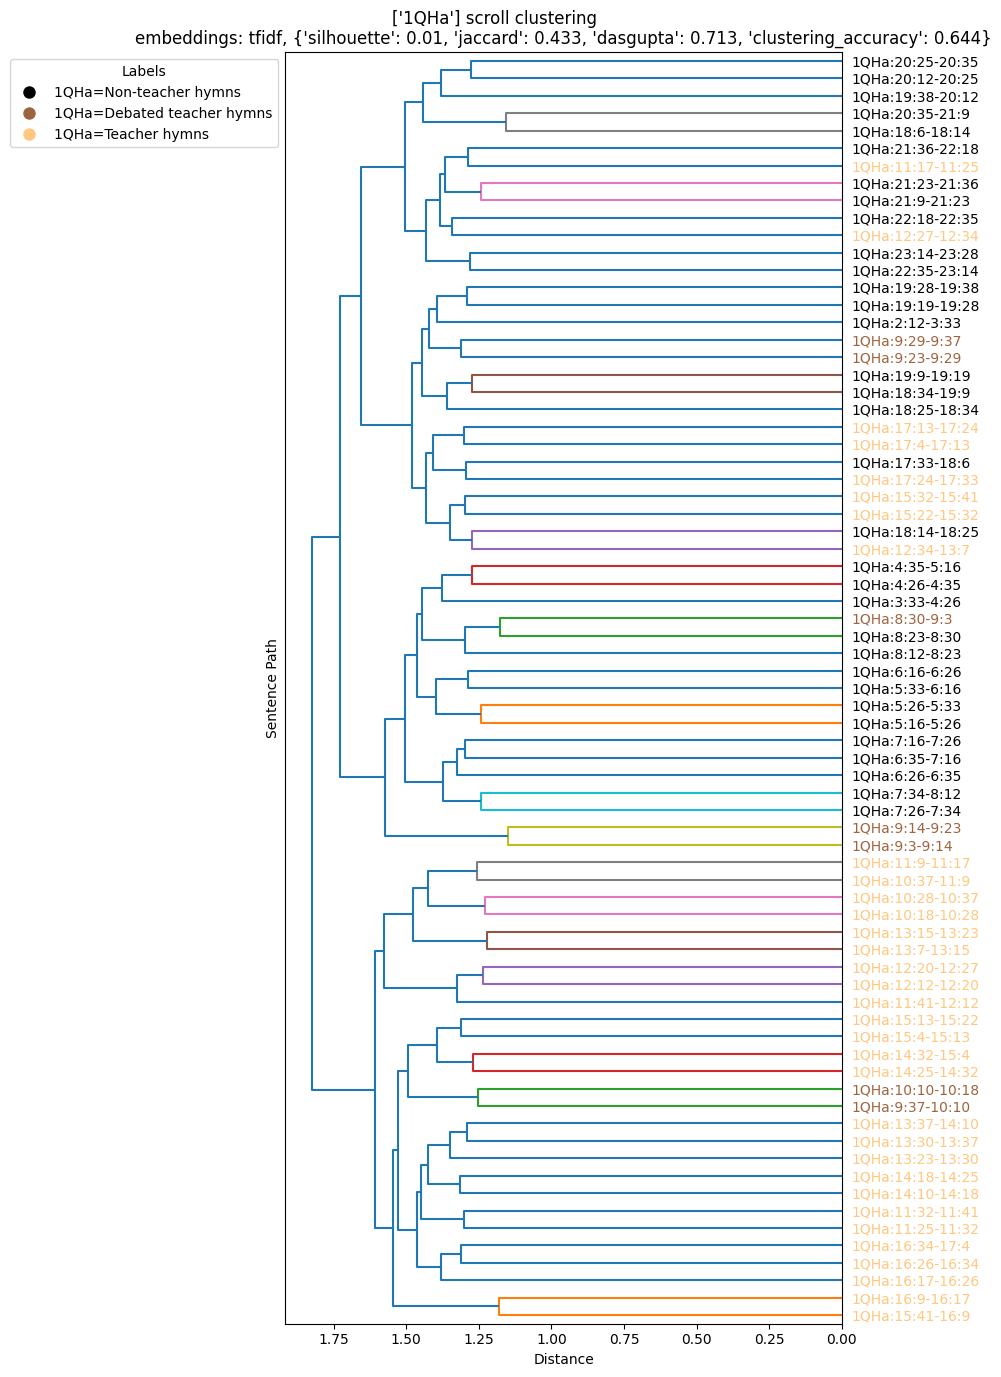

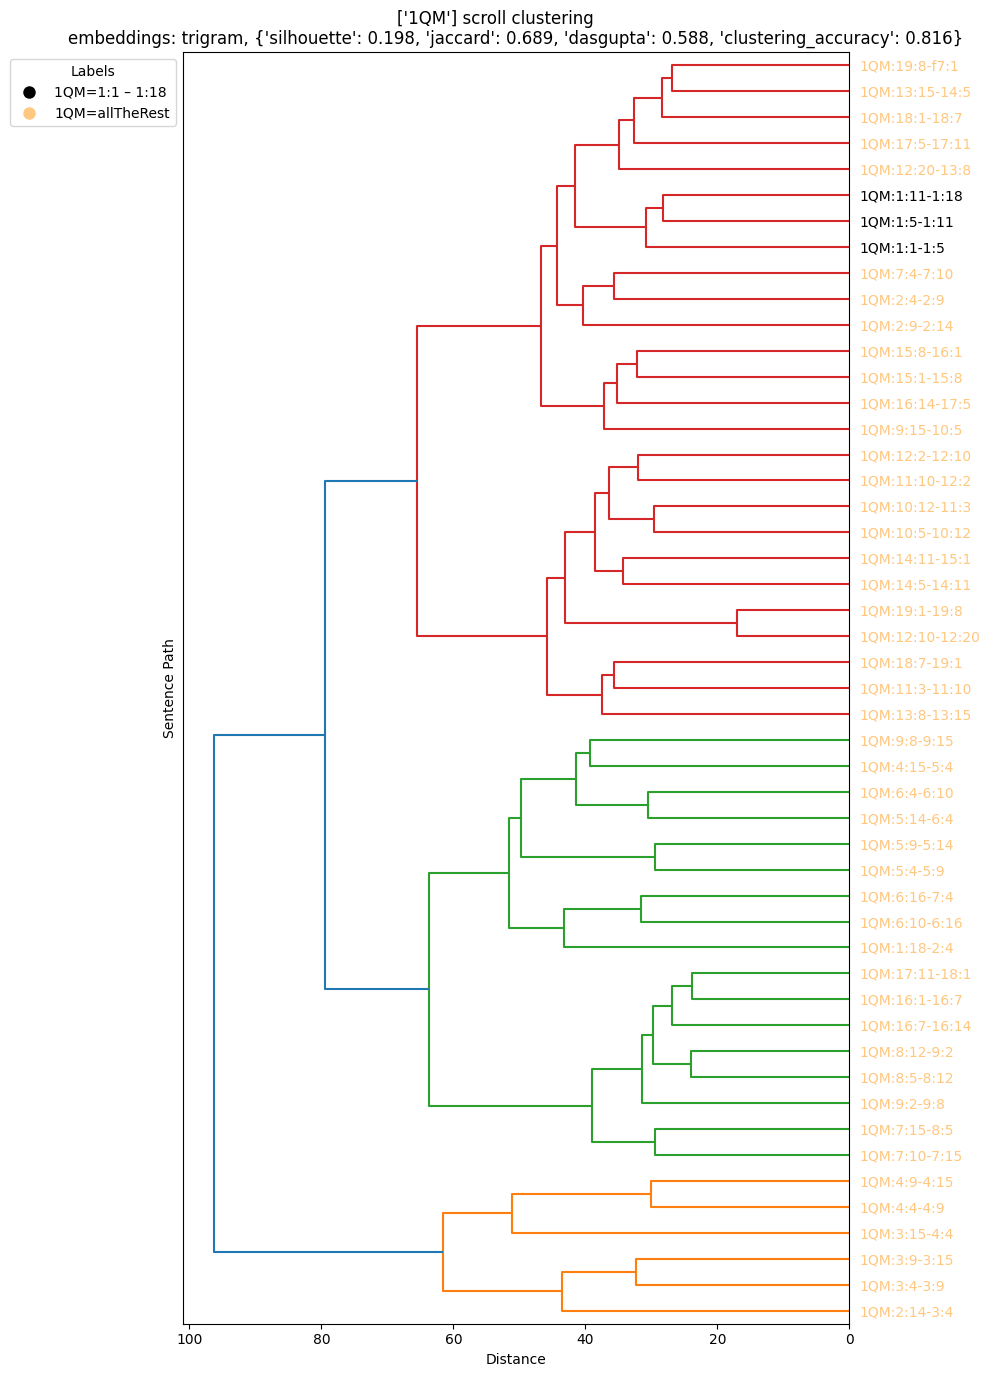

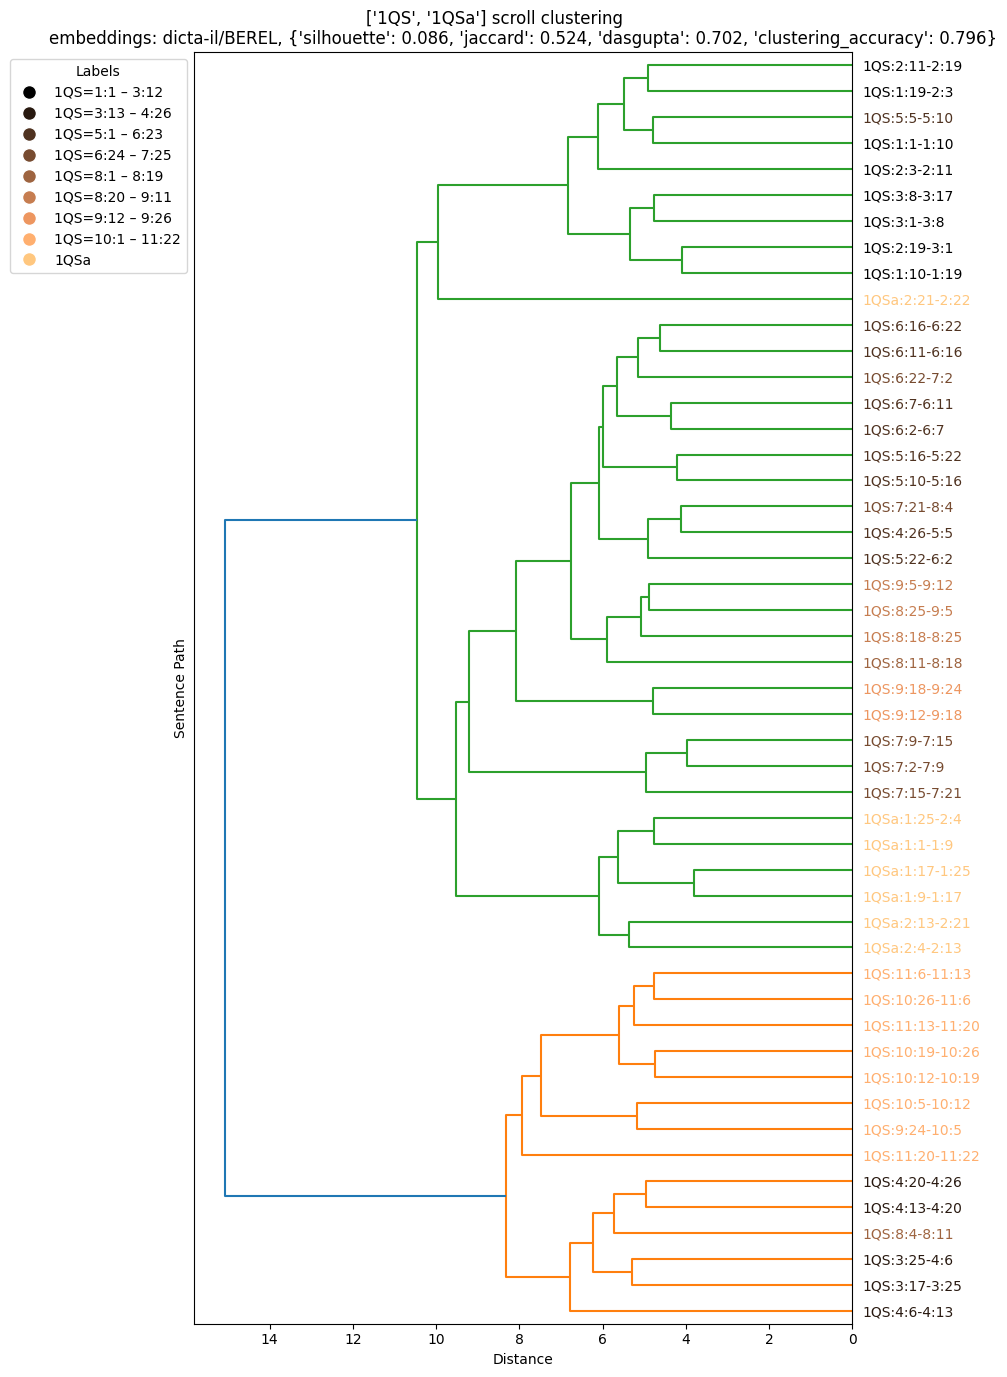

In [16]:
for i, row in results.loc[results.groupby("scroll")["jaccard"].idxmax()].iterrows():
    scroll_name = row['scroll']
    hirerchial_clustering_by_scroll(df, eval(row['scroll']), labels_all[row['scroll']], row['vectorizer'],
                                    processed_vectorizers, adjacency_matrix_all, "sentence_path", {"linkage_m": "ward"})

## Stacking features + PCA - deprecated
Looks like it not giving better results

In [13]:
from sklearn.decomposition import PCA


def stack_embeddings_and_pca(processed_vectorizers, vectorizer_to_stack, out_dim=768):
    embeddings_lst = []
    for vec_name in vectorizer_to_stack:
        tmp_arr = processed_vectorizers[vec_name]
        if isinstance(tmp_arr, scipy.sparse.csr_matrix):
            tmp_arr = tmp_arr.toarray()  # Convert sparse to dense
        embeddings_lst.append(tmp_arr)

    stacked_embeddings = np.hstack(embeddings_lst)
    print(f"Shape of stacked embeddings: {stacked_embeddings.shape}")

    pca = PCA(n_components=out_dim)
    pca.fit(stacked_embeddings)
    pca_emb = pca.transform(stacked_embeddings)
    print(f"Shape of PCA embeddings: {pca_emb.shape}")
    return pca_emb


def hirerchial_clustering_by_scroll_stacked_vectorizers(df: pd.DataFrame, curr_scroll: list[str], labels: dict,
                                                        vec_type: list[str],
                                                        processed_vectorizers: dict, adjacency_matrix, label_to_plot,
                                                        kwargs):
    linkage_m = kwargs["linkage_m"]
    #get labels
    df_labeled_for_clustering = df[df["book"].isin(curr_scroll)]
    df_labeled_for_clustering = label_sentence_path(df_labeled_for_clustering, labels, verbose=False)

    #get embeddings
    embeddings = stack_embeddings_and_pca(processed_vectorizers, vec_type, out_dim=768)
    label_idxs = list(df_labeled_for_clustering.index)
    adjacency_matrix_tmp = adjacency_matrix[label_idxs, :][
                           :, label_idxs]
    embeddings_tmp = embeddings[label_idxs]
    if type(embeddings_tmp) == scipy.sparse._csr.csr_matrix:
        embeddings_tmp = embeddings_tmp.toarray()

    #get metrics and linkage
    linkage_matrix, metrics = cluster_and_get_metrics(df_labeled_for_clustering, embeddings_tmp, adjacency_matrix_tmp,
                                                      linkage_m)

    #plot
    if label_to_plot:
        generate_dendrogram_plot(df_labeled_for_clustering, linkage_matrix, vec_type, metrics, curr_scroll,
                                 label_to_plot)
    return metrics


In [15]:
results.loc[results.groupby("scroll")["jaccard"].idxmax()]

,silhouette,jaccard,dasgupta,clustering_accuracy,vectorizer,scroll,n_labels,linkage_m
8,0.010445,0.432727,0.713463,0.643836,tfidf,['1QHa'],5,ward
27,0.198404,0.689119,0.588115,0.816327,trigram,['1QM'],2,ward
10,0.086068,0.523810,0.701708,0.795918,dicta-il/BEREL,"['1QS', '1QSa']",9,ward


In [16]:
curr_best = results.loc[results.groupby("scroll")["jaccard"].idxmax()]

vectorizer_to_stack = ['dicta-il/BEREL', 'trigram', 'tfidf']

stats_pca = []

for i, row in curr_best.iterrows():
    scroll_name = row['scroll']
    metrics = hirerchial_clustering_by_scroll_stacked_vectorizers(df, eval(row['scroll']), labels_all[row['scroll']],
                                                                  vectorizer_to_stack,
                                                                  processed_vectorizers, adjacency_matrix_all, None,
                                                                  {"linkage_m": "ward"})
    metrics.update({"scroll": eval(row['scroll']), "vectorizer": str(vectorizer_to_stack)})
    stats_pca.append(metrics)

Shape of stacked embeddings: (978, 25674)
Shape of PCA embeddings: (978, 768)
Shape of stacked embeddings: (978, 25674)
Shape of PCA embeddings: (978, 768)
Shape of stacked embeddings: (978, 25674)
Shape of PCA embeddings: (978, 768)


In [17]:
stats_df_pca = pd.DataFrame(stats_pca)
stats_df_pca["vectorizer"] = stats_df_pca["vectorizer"].astype(str)
stats_df_pca["scroll"] = stats_df_pca["scroll"].astype(str)
stats_df_pca.sort_values(by=["scroll", "dasgupta"], ascending=False)


,silhouette,jaccard,dasgupta,clustering_accuracy,scroll,vectorizer
2,0.050315,0.268182,0.628596,0.551020,"['1QS', '1QSa']","['dicta-il/BEREL', 'trigram', 'tfidf']"
1,0.197173,0.689119,0.609346,0.816327,['1QM'],"['dicta-il/BEREL', 'trigram', 'tfidf']"
0,0.055231,0.297647,0.561312,0.493151,['1QHa'],"['dicta-il/BEREL', 'trigram', 'tfidf']"


In [20]:

results.sort_values(by=["scroll", "dasgupta"], ascending=False)


,silhouette,jaccard,dasgupta,clustering_accuracy,vectorizer,scroll,n_labels,linkage_m
18,0.042057,0.434066,0.768369,0.653061,tfidf,"['1QS', '1QSa']",9,ward
14,0.088521,0.517766,0.733233,0.775510,yonatanlou/BEREL-finetuned-DSS-maskedLM,"['1QS', '1QSa']",9,ward
10,0.086068,0.523810,0.701708,0.795918,dicta-il/BEREL,"['1QS', '1QSa']",9,ward
11,0.097250,0.245734,0.681909,0.612245,onlplab/alephbert-base,"['1QS', '1QSa']",9,ward
17,0.049689,0.268182,0.632572,0.551020,trigram,"['1QS', '1QSa']",9,ward
15,0.089688,0.204461,0.626973,0.551020,yonatanlou/alephbert-base-finetuned-DSS-maskedLM,"['1QS', '1QSa']",9,ward
16,0.077350,0.241667,0.613665,0.571429,yonatanlou/dictabert-finetuned-DSS-maskedLM,"['1QS', '1QSa']",9,ward
13,0.075874,0.272358,0.609080,0.591837,dicta-il/MsBERT,"['1QS', '1QSa']",9,ward
12,0.071828,0.280172,0.590579,0.612245,dicta-il/dictabert,"['1QS', '1QSa']",9,ward
19,0.830267,0.111245,0.360693,0.285714,starr,"['1QS', '1QSa']",9,ward


### GVAE

Checking all GVAE berts:


In [41]:
from src.hierarchial_clustering.clustering_within_scroll import get_metrics_per_model
from src.baselines.embeddings import get_bert_models
import os
from tqdm.notebook import tqdm
DOMAIN = "dss"
models_dir = "/Users/yonatanlou/dev/QumranNLP/models"
model_files = [f for f in os.listdir(models_dir) if f.endswith('.pth')]

param_dict = {
        "num_adjs": 1,
        "epochs": 500,
        "hidden_dim": 300,
        "distance": "cosine",
        "learning_rate": 0.001,
        "threshold": 0.98,
        "adjacencies": [{"type": "tfidf", "params": {"max_features": 3000, "min_df":0.01}}],
    }

max_features_params = [2000,3000,4000,5000]
min_df_params = [0.01, 0.05]
thresholds = [0.9,0.93,0.95,0.97,0.99]
all_results = []
for min_df in tqdm(min_df_params):
    for max_feat in tqdm(max_features_params):
        for threshold in thresholds:
            for bert_model in tqdm(get_bert_models(DOMAIN)):
                for model_file in model_files:
                    # print(f"{model_file=}, {bert_model=}")
                    param_dict["threshold"] = threshold
                    param_dict["adjacencies"][0]["params"].update({"max_features": max_feat, "min_df":min_df})
                    result = get_metrics_per_model(bert_model, model_file, param_dict,label_to_plot=None,path_to_save=None)
                    result = [{**res, "max_features": max_feat, "min_df": min_df, "threshold":threshold} for res in result]
                    all_results.extend(result)
                    # print()


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:17:52.683992 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:17:52.884514 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:17:53.082618 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:17:53.293266 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:17:53.472130 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:17:53.630267 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:17:53.781280 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:17:53.948736 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:17:54.091888 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:17:54.249130 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:17:54.

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:17:58.516578 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:17:58.669119 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:17:58.811158 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:17:58.955532 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:17:59.163236 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:17:59.316478 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:17:59.457066 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:17:59.593770 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:17:59.804803 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:17:59.939211 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:18:00.

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:18:04.327492 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:18:04.484411 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:18:04.653300 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:18:04.809922 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:18:04.997330 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:18:05.184463 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:18:05.354518 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:18:05.513469 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:18:05.663785 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:18:05.804886 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:18:05.

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:18:09.850758 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:18:09.987976 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:18:10.136457 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:18:10.270963 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:18:10.407250 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:18:10.545656 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:18:10.698094 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:18:10.848990 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:18:10.992210 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:18:11.138112 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:18:11.289464 - t

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:18:15.403517 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:18:15.544377 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:18:15.707799 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:18:15.880081 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:18:16.042233 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:18:16.181177 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:18:16.324113 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:18:16.529004 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:18:16.678551 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:18:16.837045 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:18:17.021562 - t

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:18:21.295797 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:18:21.456760 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:18:21.613765 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:18:21.771671 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:18:21.924188 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:18:22.087449 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:18:22.246593 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:18:22.462347 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:18:22.666530 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:18:22.849748 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:18:23.

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:18:29.964190 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:18:30.317372 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:18:30.556600 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:18:30.758319 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:18:31.080808 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:18:31.542188 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:18:31.944740 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:18:32.204476 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:18:32.468458 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:18:32.643279 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:18:32.

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:18:38.251112 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:18:38.402122 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:18:38.551663 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:18:38.704175 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:18:38.852530 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:18:38.994545 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:18:39.139536 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:18:39.288988 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:18:39.437967 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:18:39.588949 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:18:39.

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:18:44.330292 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:18:44.513771 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:18:44.713872 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:18:44.961481 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:18:45.138713 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:18:45.359056 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:18:45.522606 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:18:45.700315 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:18:45.904840 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:18:46.097085 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:18:46.291634 - t

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:18:51.140588 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:18:51.391678 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:18:51.848010 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:18:52.182272 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:18:52.447195 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:18:52.685650 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:18:52.928766 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:18:53.184194 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:18:53.399325 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:18:53.626334 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:18:53.786804 - t

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:18:58.167820 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:18:58.354648 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:18:58.569280 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:18:58.778600 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:18:58.958342 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:18:59.120725 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:18:59.311144 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:18:59.493753 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:18:59.662518 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:18:59.856844 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:19:00.

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:19:04.481287 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:19:04.628642 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:19:04.791916 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:19:04.961507 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:19:05.133169 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:19:05.302811 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:19:05.482344 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:19:05.667539 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:19:05.844440 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:19:06.018083 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:19:06.

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:19:10.847166 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:19:11.017437 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:19:11.187755 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:19:11.372037 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:19:11.551195 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:19:11.718742 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:19:11.899463 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:19:12.086591 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:19:12.261162 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:19:12.422814 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:19:12.

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:19:17.004255 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:19:17.169480 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:19:17.323482 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:19:17.480295 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:19:17.651210 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:19:17.834968 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:19:18.013357 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:19:18.200691 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:19:18.383626 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:19:18.566884 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:19:18.742737 - t

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:19:23.156287 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:19:23.308783 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:19:23.451320 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:19:23.608506 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:19:23.759400 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:19:23.906005 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:19:24.054341 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:19:24.202259 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:19:24.343065 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:19:24.479282 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:19:24.640154 - t

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:19:28.884964 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:19:29.084231 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:19:29.283254 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:19:29.476773 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:19:29.685317 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:19:29.882106 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:19:30.100662 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:19:30.305382 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:19:30.471333 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:19:30.656393 - tfidf n edges before filtering: 31818, n edges after filtering: 3240
2024-11-29 10:19:30.

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:19:35.606146 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:19:35.786850 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:19:35.969498 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:19:36.146920 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:19:36.332931 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:19:36.514003 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:19:36.678772 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:19:36.842113 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:19:37.025626 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:19:37.206980 - tfidf n edges before filtering: 31818, n edges after filtering: 2268
2024-11-29 10:19:37.

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:19:42.139011 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:19:42.295189 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:19:42.651489 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:19:42.914812 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:19:43.076030 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:19:43.272448 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:19:43.468086 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:19:43.648013 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:19:43.838065 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:19:44.042744 - tfidf n edges before filtering: 31818, n edges after filtering: 1620
2024-11-29 10:19:44.

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:19:48.932710 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:19:49.117341 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:19:49.294385 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:19:49.470294 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:19:49.621400 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:19:49.802730 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:19:49.984559 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:19:50.193217 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:19:50.553785 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:19:50.729914 - tfidf n edges before filtering: 31818, n edges after filtering: 972
2024-11-29 10:19:50.909325 - t

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:19:55.512899 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:19:55.687382 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:19:55.853117 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:19:56.009874 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:19:56.173941 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:19:56.351169 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:19:56.541457 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:19:56.703914 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:19:56.859009 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:19:57.014537 - tfidf n edges before filtering: 31818, n edges after filtering: 324
2024-11-29 10:19:57.177037 - t

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:20:02.094606 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:20:02.290896 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:20:02.456034 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:20:02.625220 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:20:02.807910 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:20:02.997591 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:20:03.182773 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:20:03.352305 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:20:03.531900 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:20:03.700573 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:20:03.

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:20:08.380296 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:20:08.545788 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:20:08.718220 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:20:08.882556 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:20:09.052666 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:20:09.210246 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:20:09.415562 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:20:09.583146 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:20:09.736873 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:20:09.897825 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:20:10.

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:20:14.561019 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:20:14.719865 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:20:14.877539 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:20:15.052656 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:20:15.212930 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:20:15.374689 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:20:15.547543 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:20:15.711014 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:20:15.886772 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:20:16.047493 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:20:16.

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:20:20.522102 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:20:20.671891 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:20:20.830619 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:20:20.987114 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:20:21.138571 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:20:21.292063 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:20:21.444029 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:20:21.606730 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:20:21.771728 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:20:21.960753 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:20:22.134512 - t

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:20:26.408684 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:20:26.558788 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:20:26.705664 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:20:26.862306 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:20:27.008313 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:20:27.151721 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:20:27.301920 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:20:27.456199 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:20:27.607414 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:20:27.775680 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:20:27.936152 - t

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:20:32.084568 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:20:32.256480 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:20:32.449399 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:20:32.644938 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:20:32.820723 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:20:32.978880 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:20:33.157769 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:20:33.317025 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:20:33.480760 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:20:33.650449 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:20:33.

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:20:38.243228 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:20:38.404126 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:20:38.595186 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:20:38.775612 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:20:38.951997 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:20:39.118428 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:20:39.285904 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:20:39.448613 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:20:39.603941 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:20:39.755146 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:20:39.

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:20:44.158407 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:20:44.346678 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:20:44.524799 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:20:44.715188 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:20:44.876234 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:20:45.049000 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:20:45.235176 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:20:45.393823 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:20:45.566449 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:20:45.740616 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:20:45.

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:20:50.313482 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:20:50.466359 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:20:50.616928 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:20:50.779764 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:20:50.932105 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:20:51.089504 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:20:51.246625 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:20:51.404458 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:20:51.556972 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:20:51.723109 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:20:51.879637 - t

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:20:56.343890 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:20:56.500649 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:20:56.654844 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:20:56.806387 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:20:56.958629 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:20:57.108213 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:20:57.264384 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:20:57.418239 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:20:57.568443 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:20:57.718045 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:20:57.883489 - t

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:21:02.197949 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:21:02.376519 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:21:02.555646 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:21:02.741323 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:21:02.927416 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:21:03.112506 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:21:03.292955 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:21:03.474109 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:21:03.650496 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:21:03.839404 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:21:04.

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:21:08.667446 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:21:08.861116 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:21:09.033570 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:21:09.210841 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:21:09.384575 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:21:09.539921 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:21:09.711591 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:21:09.879972 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:21:10.040237 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:21:10.240800 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:21:10.

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:21:14.486970 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:21:14.651132 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:21:14.805761 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:21:14.956447 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:21:15.110169 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:21:15.264407 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:21:15.433014 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:21:15.595921 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:21:15.763081 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:21:15.924058 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:21:16.

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:21:20.176316 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:21:20.344782 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:21:20.495330 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:21:20.668381 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:21:20.825202 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:21:20.986263 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:21:21.146113 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:21:21.300654 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:21:21.460827 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:21:21.609087 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:21:21.769195 - t

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:21:26.193600 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:21:26.367441 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:21:26.529617 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:21:26.708253 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:21:26.873586 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:21:27.062062 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:21:27.274515 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:21:27.456262 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:21:27.631167 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:21:27.795153 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:21:27.941189 - t

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:21:31.981097 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:21:32.131121 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:21:32.304268 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:21:32.457907 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:21:32.614853 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:21:32.767086 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:21:32.922038 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:21:33.073608 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:21:33.236151 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:21:33.383634 - tfidf n edges before filtering: 31696, n edges after filtering: 3240
2024-11-29 10:21:33.

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:21:38.071150 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:21:38.253505 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:21:38.451404 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:21:38.616087 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:21:38.772670 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:21:38.928832 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:21:39.105351 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:21:39.280350 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:21:39.442925 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:21:39.608153 - tfidf n edges before filtering: 31696, n edges after filtering: 2268
2024-11-29 10:21:39.

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:21:44.100172 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:21:44.270622 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:21:44.432271 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:21:44.597810 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:21:44.762230 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:21:44.919766 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:21:45.090805 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:21:45.257131 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:21:45.420740 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:21:45.589621 - tfidf n edges before filtering: 31696, n edges after filtering: 1620
2024-11-29 10:21:45.

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:21:49.982326 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:21:50.145326 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:21:50.302021 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:21:50.467780 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:21:50.652828 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:21:50.825923 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:21:51.006632 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:21:51.176714 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:21:51.352273 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:21:51.517117 - tfidf n edges before filtering: 31696, n edges after filtering: 972
2024-11-29 10:21:51.676626 - t

  0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 10:21:55.895449 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:21:56.051535 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:21:56.208572 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:21:56.370542 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:21:56.542090 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:21:56.716327 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:21:56.894092 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:21:57.064847 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:21:57.230549 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:21:57.406094 - tfidf n edges before filtering: 31696, n edges after filtering: 324
2024-11-29 10:21:57.573821 - t

In [57]:
import pandas as pd
all_results_pd = pd.DataFrame(all_results)
all_results_pd.sort_values(by=["scroll","dasgupta"],ascending=False).groupby("scroll").head(6)

,silhouette,jaccard,dasgupta,clustering_accuracy,scroll,vectorizer,model_file,max_features,min_df,threshold
905,0.299619,0.368889,0.787114,0.612245,"['1QS', '1QSa']",GVAE-dicta-il/dictabert,trained_gvae_model_BEREL.pth,3000,0.01,0.97
1445,0.299619,0.368889,0.787114,0.612245,"['1QS', '1QSa']",GVAE-dicta-il/dictabert,trained_gvae_model_BEREL.pth,4000,0.01,0.97
1985,0.299619,0.368889,0.787114,0.612245,"['1QS', '1QSa']",GVAE-dicta-il/dictabert,trained_gvae_model_BEREL.pth,5000,0.01,0.97
377,0.307368,0.359091,0.785937,0.632653,"['1QS', '1QSa']",GVAE-dicta-il/dictabert,trained_gvae_model_dictabert.pth,2000,0.01,0.97
935,0.334404,0.412000,0.784274,0.714286,"['1QS', '1QSa']",GVAE-yonatanlou/BEREL-finetuned-DSS-maskedLM,trained_gvae_model_dictabert.pth,3000,0.01,0.97
1475,0.334404,0.412000,0.784274,0.714286,"['1QS', '1QSa']",GVAE-yonatanlou/BEREL-finetuned-DSS-maskedLM,trained_gvae_model_dictabert.pth,4000,0.01,0.97
1029,0.236863,0.471767,0.657997,0.591837,['1QM'],GVAE-yonatanlou/BEREL-finetuned-DSS-maskedLM,trained_gvae_model_BEREL.pth,3000,0.01,0.99
1569,0.236863,0.471767,0.657997,0.591837,['1QM'],GVAE-yonatanlou/BEREL-finetuned-DSS-maskedLM,trained_gvae_model_BEREL.pth,4000,0.01,0.99
2109,0.236863,0.471767,0.657997,0.591837,['1QM'],GVAE-yonatanlou/BEREL-finetuned-DSS-maskedLM,trained_gvae_model_BEREL.pth,5000,0.01,0.99
381,0.321781,0.471767,0.657762,0.591837,['1QM'],GVAE-yonatanlou/BEREL-finetuned-DSS-maskedLM,trained_gvae_model_BEREL.pth,2000,0.01,0.97


Loaded the embeddings: ['dicta-il/BEREL', 'onlplab/alephbert-base', 'dicta-il/dictabert', 'yonatanlou/BEREL-finetuned-DSS-maskedLM', 'tfidf', 'trigram', 'starr', 'yonatanlou/alephbert-base-finetuned-DSS-maskedLM', 'yonatanlou/dictabert-finetuned-DSS-maskedLM', 'dicta-il/MsBERT']
Loaded the following embeddings dict_keys(['dicta-il/BEREL', 'onlplab/alephbert-base', 'dicta-il/dictabert', 'yonatanlou/BEREL-finetuned-DSS-maskedLM', 'tfidf', 'trigram', 'starr', 'yonatanlou/alephbert-base-finetuned-DSS-maskedLM', 'yonatanlou/dictabert-finetuned-DSS-maskedLM', 'dicta-il/MsBERT'])


Building adjacency matrix: 100%|██████████| 978/978 [00:01<00:00, 916.54it/s]


2024-11-29 10:38:09.579164 - tfidf n edges before filtering: 31818, n edges after filtering: 972


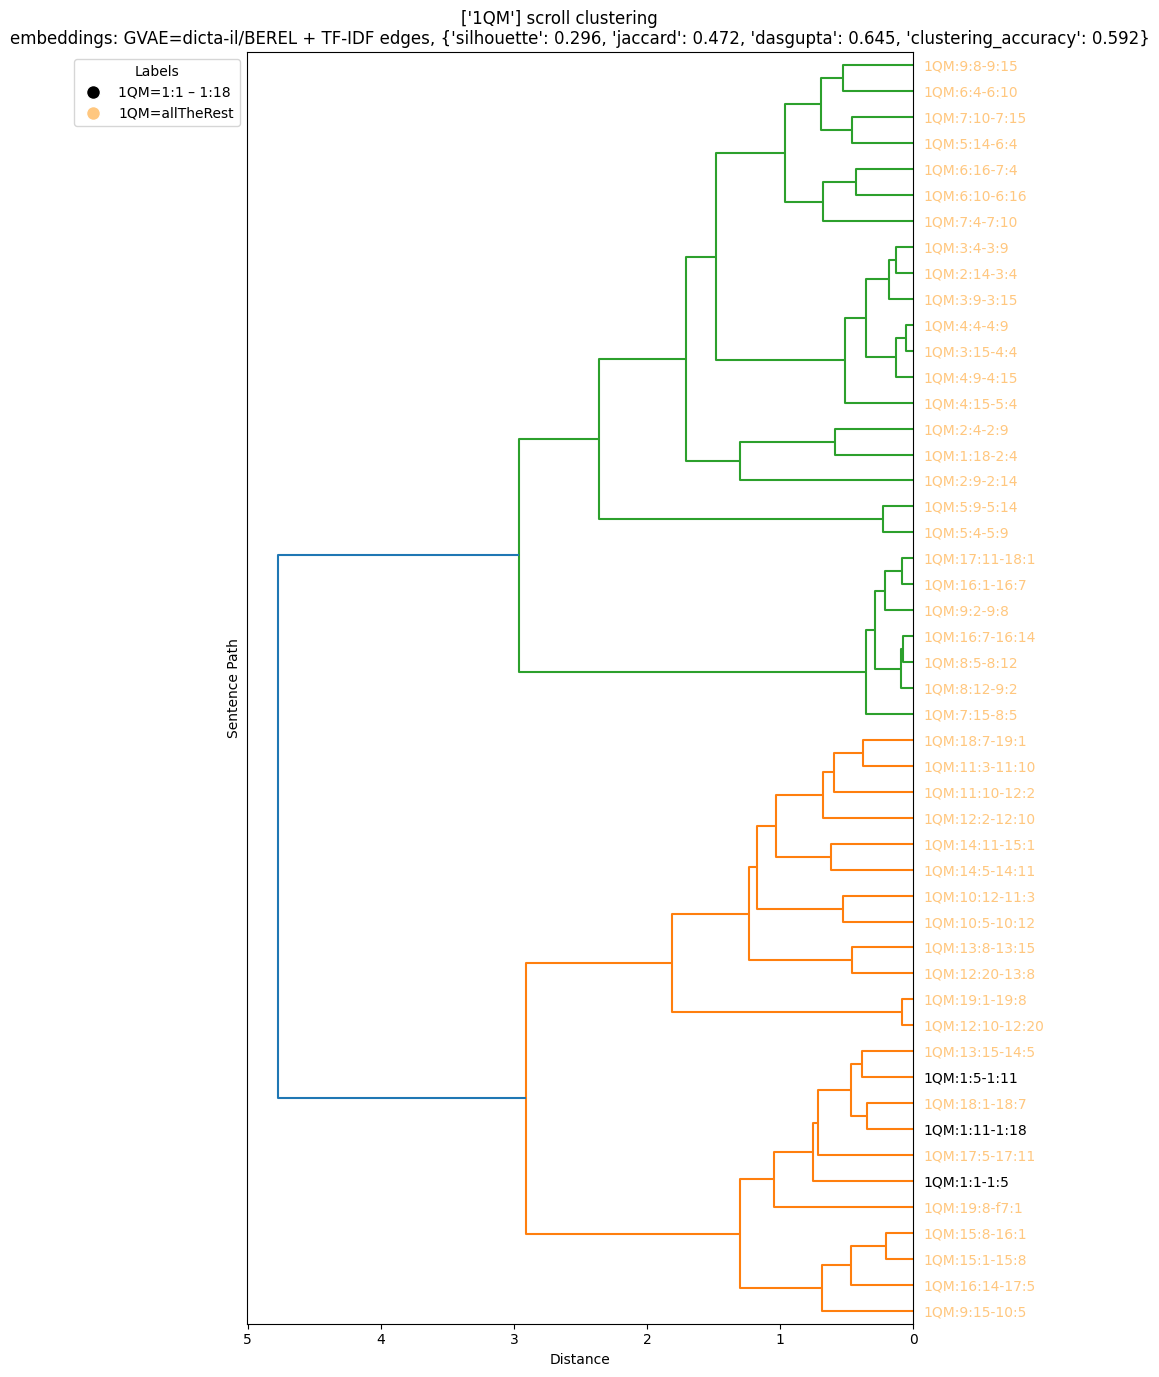

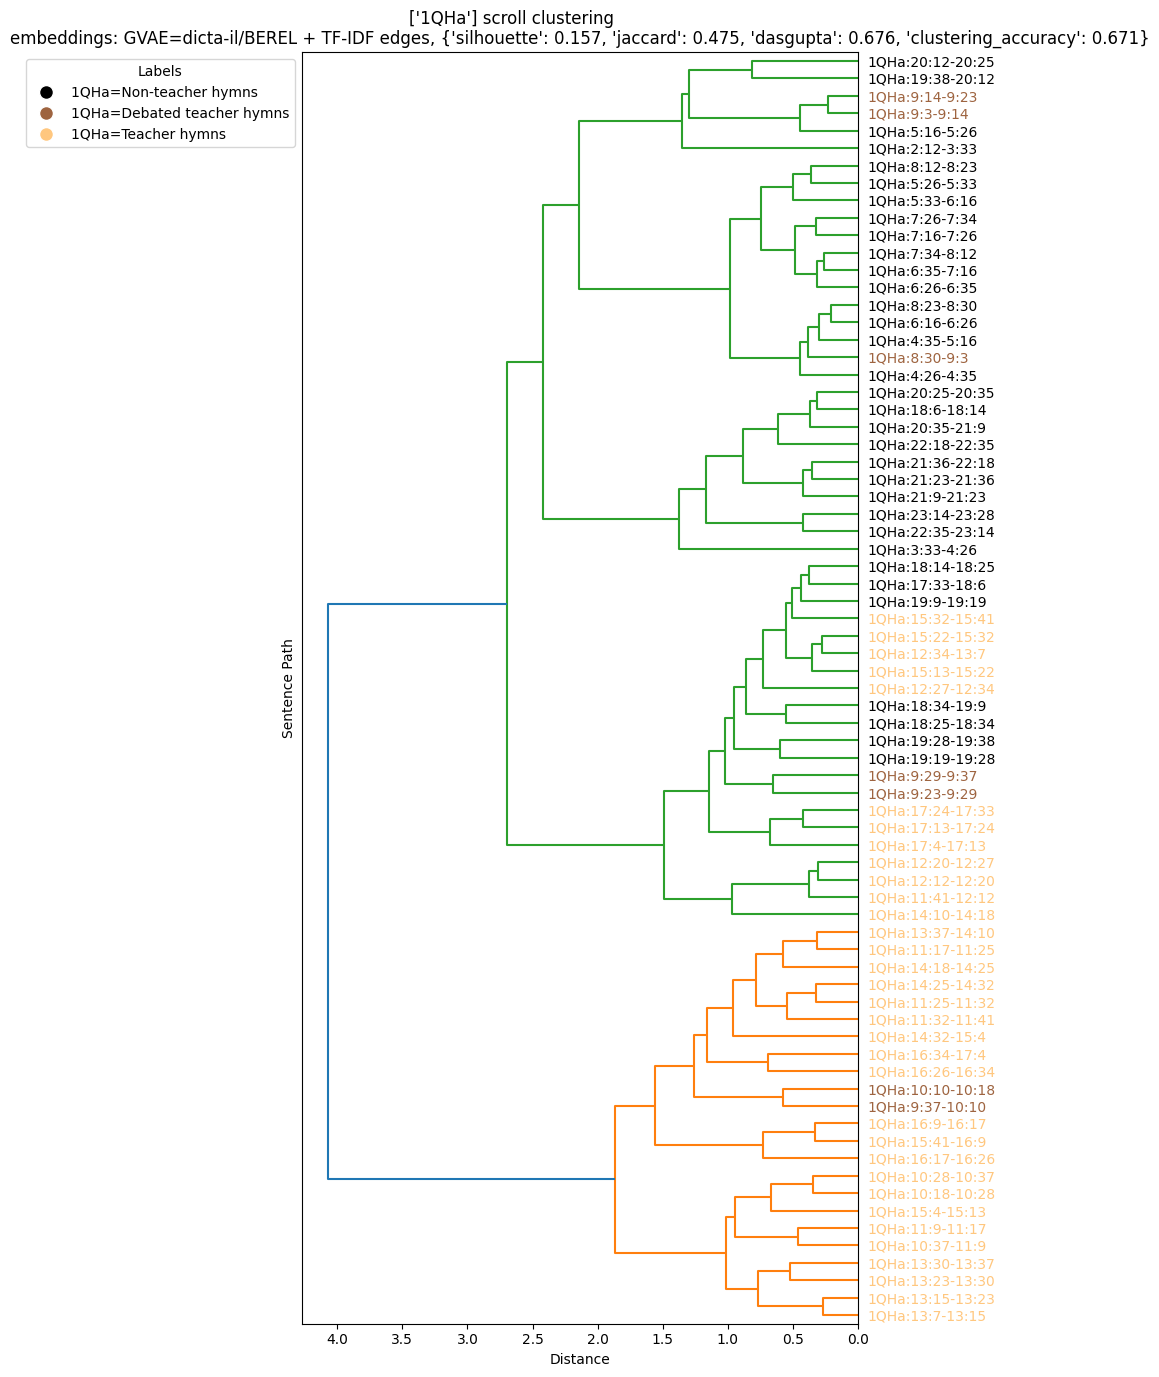

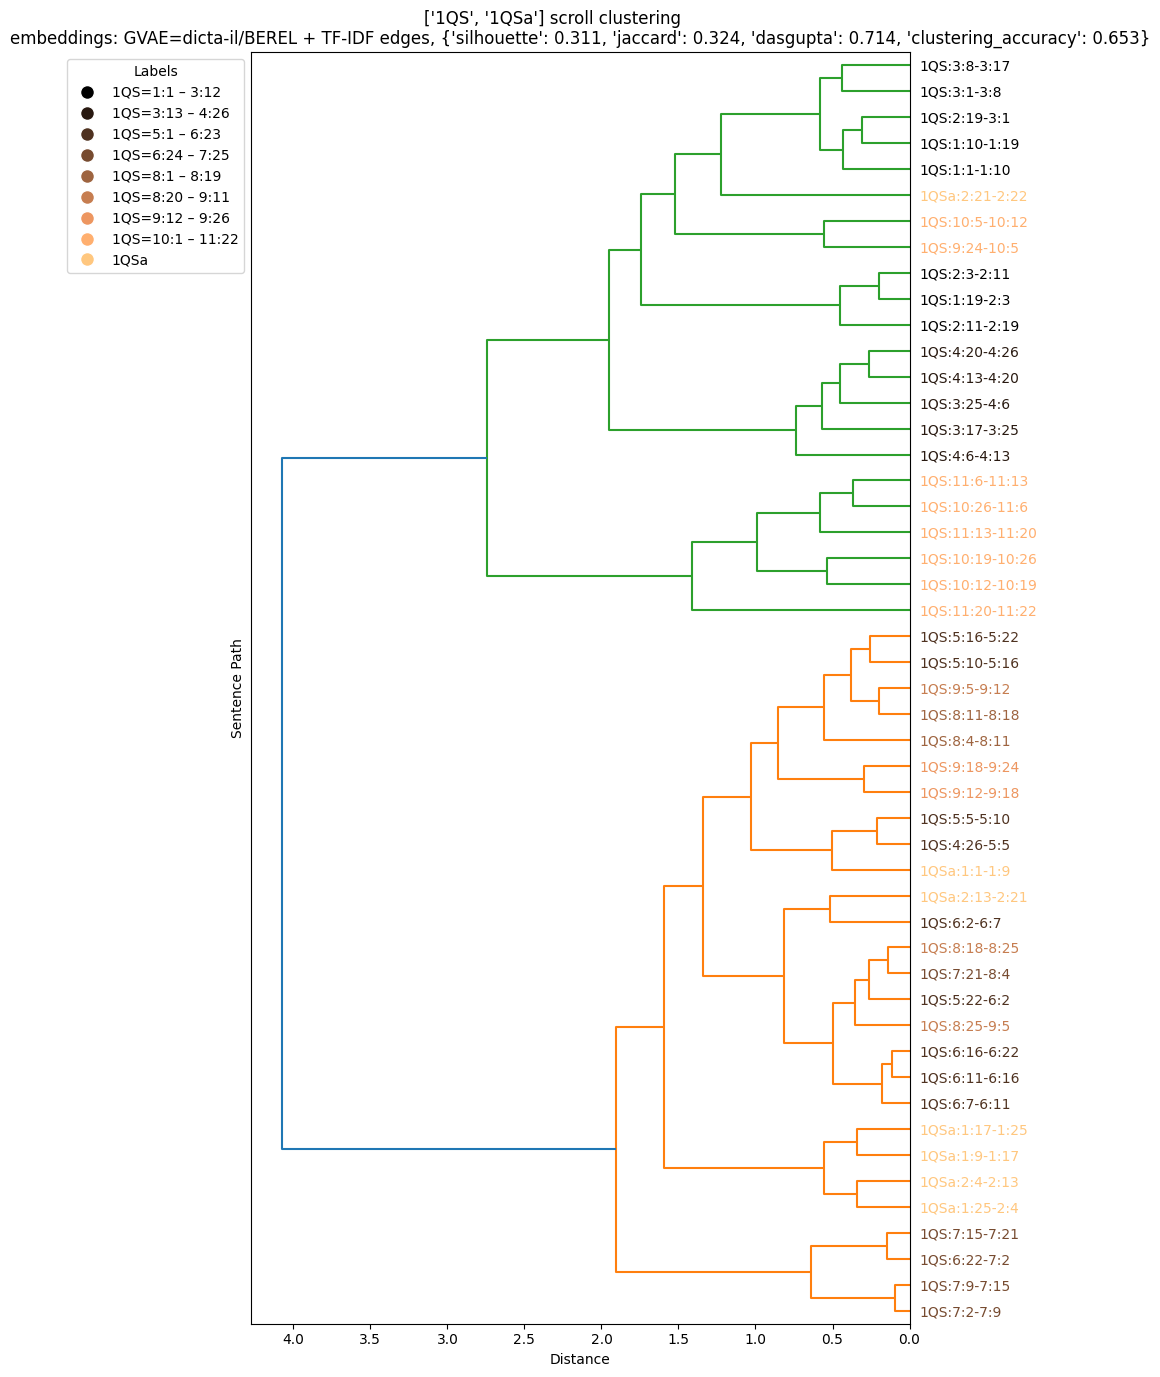

,silhouette,jaccard,dasgupta,clustering_accuracy,scroll,vectorizer,model_file
0,0.296451,0.471767,0.644600,0.591837,['1QM'],dicta-il/BEREL,trained_gvae_model_BEREL-finetuned-DSS-maskedL...
1,0.157034,0.475360,0.675997,0.671233,['1QHa'],dicta-il/BEREL,trained_gvae_model_BEREL-finetuned-DSS-maskedL...
2,0.311216,0.323529,0.714123,0.653061,"['1QS', '1QSa']",dicta-il/BEREL,trained_gvae_model_BEREL-finetuned-DSS-maskedL...


In [61]:
from src.hierarchial_clustering.clustering_within_scroll import get_metrics_per_model
from src.baselines.embeddings import get_bert_models
import os
from tqdm.notebook import tqdm
DOMAIN = "dss"
models_dir = "/Users/yonatanlou/dev/QumranNLP/models"


param_dict = {
        "num_adjs": 1,
        "epochs": 500,
        "hidden_dim": 300,
        "distance": "cosine",
        "learning_rate": 0.001,
        "threshold": 0.97,
        "adjacencies": [{"type": "tfidf", "params": {"max_features": 4000, "min_df":0.001}}],
    }

all_results = []


bert_model = "dicta-il/BEREL"
# model_file = "trained_gvae_model_dictabert-finetuned-DSS-maskedLM.pth"
model_file = "trained_gvae_model_BEREL-finetuned-DSS-maskedLM.pth"
result = get_metrics_per_model(bert_model, model_file, param_dict,label_to_plot="sentence_path",path_to_save=None)
all_results.extend(result)
# print()
pd.DataFrame(all_results)